# Práctica 7: Detección de Objetos

Participantes:
- Gerardo León Quintana
- Susana Suárez Mendoza

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import time
from ultralytics import YOLO
from handperson  import HandPerson
from savedata import SaveData
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
def lucas_kanade(image1, image2, window_size):
    """
    Implementa el método de Lucas-Kanade para el registro de imágenes.

    Args:
        image1 (ndarray): La imagen de referencia.
        image2 (ndarray): La imagen a registrar.
        window_size (int): Tamaño de la ventana para calcular el flujo óptico.

    Returns:
        u (ndarray): Desplazamientos en la dirección x.
        v (ndarray): Desplazamientos en la dirección y.
    """
    # Gradientes de la imagen
    Ix = cv.Sobel(image1, cv.CV_64F, 1, 0, ksize=5)  # Gradiente en x
    Iy = cv.Sobel(image1, cv.CV_64F, 0, 1, ksize=5)  # Gradiente en y
    It = image2.astype(np.float64) - image1.astype(np.float64)  # Gradiente temporal, mide el cambio entre las dos imágenes
    
    # u y v: Matrices para almacenar los desplazamientos (flujo) en las direcciones x e y
    u = np.zeros_like(image1, dtype=np.float64)
    v = np.zeros_like(image1, dtype=np.float64)
    
    half_window = window_size // 2
    
    # Recorre los píxeles dentro de un rango seguro, considerando el tamaño de la ventana.
    for i in range(half_window, image1.shape[0] - half_window):
        for j in range(half_window, image1.shape[1] - half_window):
            # Extraer ventanas locales
            Ix_window = Ix[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1].flatten()
            Iy_window = Iy[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1].flatten()
            It_window = It[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1].flatten()
            
            # Formar matrices locales para resolver el flujo óptico
            A = np.vstack((Ix_window, Iy_window)).T # Matriz con gradientes espciales
            b = -It_window # Gradiente temporal negativo
            # Componentes de la ecuación normal que resuelve el flujo óptico
            ATA = A.T @ A 
            ATb = A.T @ b
            
            # Calcula los desplazamientos locales (u, v) solo si ATA es invertible
            if np.linalg.det(ATA) > 1e-2:
                nuv = np.linalg.inv(ATA) @ ATb
                u[i, j], v[i, j] = nuv
                
    return u, v

## 1. Video a mano

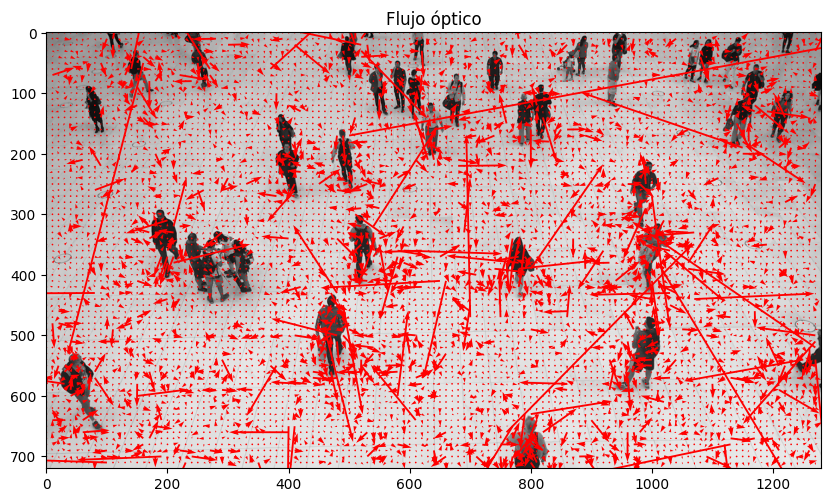

In [5]:
def process_video(video_path, window_size=5):
    # Cargar el video
    cap = cv.VideoCapture(video_path)
    ret, prev_frame = cap.read()
    
    if not ret:
        print("No se pudo leer el video.")
        return
    
    # Convertir el primer frame a escala de grises
    prev_gray = cv.cvtColor(prev_frame, cv.COLOR_BGR2GRAY)
    
    while True:
        # Leer el siguiente frame
        ret, next_frame = cap.read()
        if not ret:
            break
        
        next_gray = cv.cvtColor(next_frame, cv.COLOR_BGR2GRAY)
        
        # Aplicar Lucas-Kanade entre frames consecutivos
        u, v = lucas_kanade(prev_gray, next_gray, window_size)
        
        # Visualizar el flujo óptico
        step = 10
        plt.figure(figsize=(10, 10))
        plt.imshow(prev_gray, cmap='gray')
        plt.quiver(np.arange(0, u.shape[1], step),
                   np.arange(0, u.shape[0], step),
                   u[::step, ::step], v[::step, ::step], color='r')
        plt.title("Flujo óptico")
        plt.show()
        
        # Actualizar el frame anterior
        prev_gray = next_gray

        break
    
    cap.release()

# Ejecutar el procesamiento en el video
process_video("../videos/people2.mp4", window_size=5)


## 2. Lucas-kanade y YOLO

### 2.1. Lucas-Kanade version OpenCV

In [3]:
# Función para obtener la posición inicial de la mano
def get_hand(img, model, person_idx=3):
    detections = model(img)
    keypoints = detections[0].keypoints
    keypoint_coordinates = keypoints[person_idx].xy[0]
    right_wrists = keypoint_coordinates[10]
    return int(right_wrists[0]), int(right_wrists[1])

In [4]:
video = cv.VideoCapture("../videos/people2.mp4")
status, old_frame = video.read()
size = (old_frame.shape[1], old_frame.shape[0])

fourcc = cv.VideoWriter_fourcc(*'DIVX')
video_out = cv.VideoWriter('../videos/result_lk_opencv.mp4', fourcc, 20.0, size)

img_bgr = cv.cvtColor(old_frame, cv.COLOR_RGB2BGR)
video_out.write(img_bgr)

# Cargar el modelo YOLO
model = YOLO('./models/yolo11x-pose.pt')

# Obtener la posición inicial de la mano
hand_point = get_hand(old_frame, model)

old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)

# Inicializar el seguimiento
tracking_path = [hand_point]
tracking_path_skips = [hand_point]
i = 0
frames = [i]

# Parámetros para Lucas-Kanade
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

# Inicializar puntos para Lucas-Kanade
prev_points = np.array([hand_point], dtype=np.float32).reshape(-1, 1, 2)

# Procesamiento del video
compute_start = time.time()

while status:
    ret, frame = video.read()
    if not ret:
        break

    # Convertir a escala de grises
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # Calcular el flujo óptico usando Lucas-Kanade
    next_points, status, _ = cv.calcOpticalFlowPyrLK(old_gray, gray, prev_points, None, **lk_params)
    new_tracked_points = []

    if status[0][0] == 1:  # Si el punto fue rastreado con éxito
        x, y = next_points[0][0]
        new_tracked_points.append((x, y))
        tracking_path.append((x, y))
        tracking_path_skips.append((x, y))
        prev_points = next_points  # Actualizar el punto previo
    else:
        tracking_path_skips.append((0,0))
        new_tracked_points = tracking_path[-1:]

    i += 1
    frames.append(i)
    
    # Dibujar la trayectoria y los puntos actuales
    for i in range(1, len(tracking_path)):
        cv.line(frame,
                (int(tracking_path[i-1][0]), int(tracking_path[i-1][1])),
                (int(tracking_path[i][0]), int(tracking_path[i][1])),
                (255, 0, 0), 2)

    for (x, y) in new_tracked_points:
        cv.circle(frame, (int(x), int(y)), 5, (0, 255, 0), -1)

    # Mostrar el resultado directamente en el video
    cv.imshow('Lucas-Kanade - Mano', frame)
    video_out.write(frame)

    # Actualizar frame y escala de grises
    old_gray = gray.copy()

    if cv.waitKey(1) & 0xFF == 27:
        break

compute_end = time.time()
video.release()
video_out.release()
cv.destroyAllWindows()



0: 384x640 7 persons, 801.4ms
Speed: 3.0ms preprocess, 801.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


In [5]:
spent_time = compute_end - compute_start
spent_time_min = spent_time / 60
print(f"Time spent: {spent_time} seconds")
print(f"Time spent: {spent_time_min} minutes")

Time spent: 9.581176996231079 seconds
Time spent: 0.15968628327051798 minutes


In [6]:
x_coordinates = [float(point[0]) if hasattr(point[0], 'item') else point[0] for point in tracking_path]
y_coordinates = [float(point[1]) if hasattr(point[1], 'item') else point[1] for point in tracking_path]
x_skip = [float(point[0]) if hasattr(point[0], 'item') else point[0] for point in tracking_path_skips]
y_skip = [float(point[1]) if hasattr(point[1], 'item') else point[1] for point in tracking_path_skips]
time = [i for i in range(len(tracking_path))]
speed = np.sqrt(np.diff(x_coordinates)**2 + np.diff(y_coordinates)**2)

data = {
    "x_coordinates": x_coordinates,
    "y_coordinates": y_coordinates,
    "x_skip": x_skip,
    "y_skip": y_skip,
    "time": time,
    "time_frame": frames,
    "speed": speed.tolist(),
    "time_spent": spent_time
}

savedata = SaveData(data, "tracking_lk_opencv")
savedata.save_data()

Datos guardados en ../resultados\tracking_lk_opencv.txt


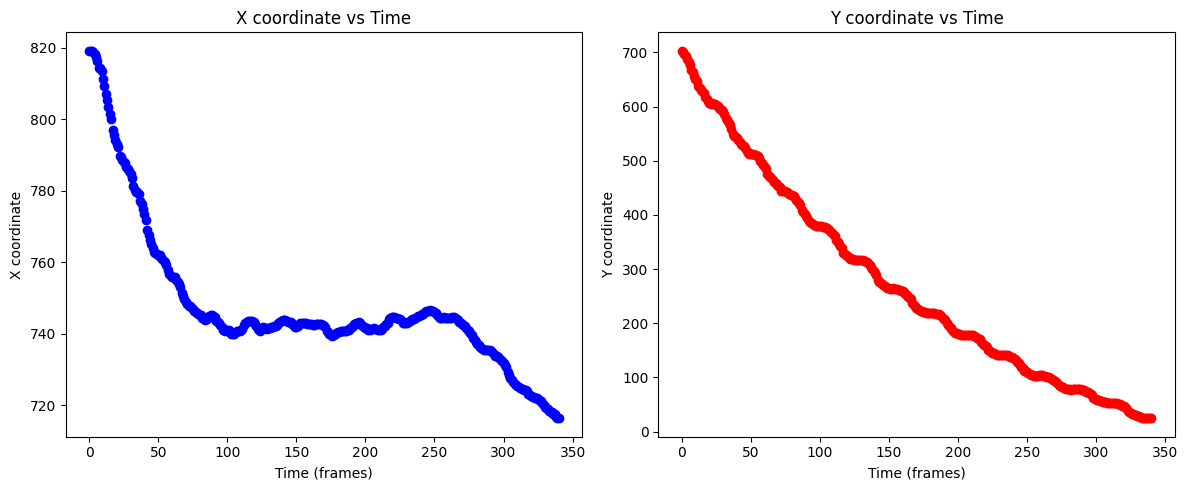

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(frames, x_skip, label="x(t)", color="blue", marker='o', linestyle='')
plt.xlabel("Time (frames)")
plt.ylabel("X coordinate")
plt.title("X coordinate vs Time")

plt.subplot(1, 2, 2)
plt.plot(frames,y_skip, label="y(t)", color="red", marker='o', linestyle='')
plt.xlabel("Time (frames)")
plt.ylabel("Y coordinate")
plt.title("Y coordinate vs Time")

plt.tight_layout()
plt.show()

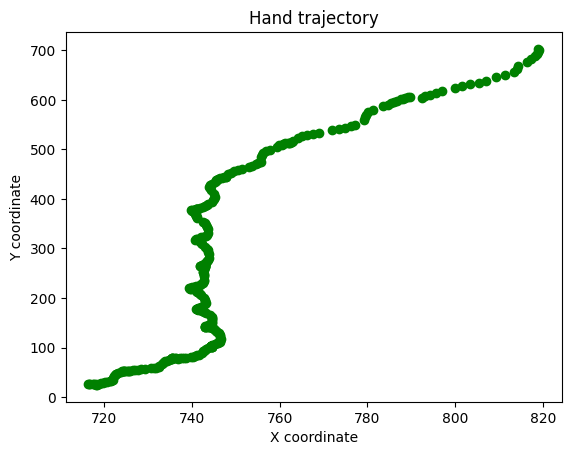

In [8]:
plt.plot(x_skip, y_skip, label="Hand trajectory", color="green", marker='o', linestyle='')
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Hand trajectory")
plt.show()

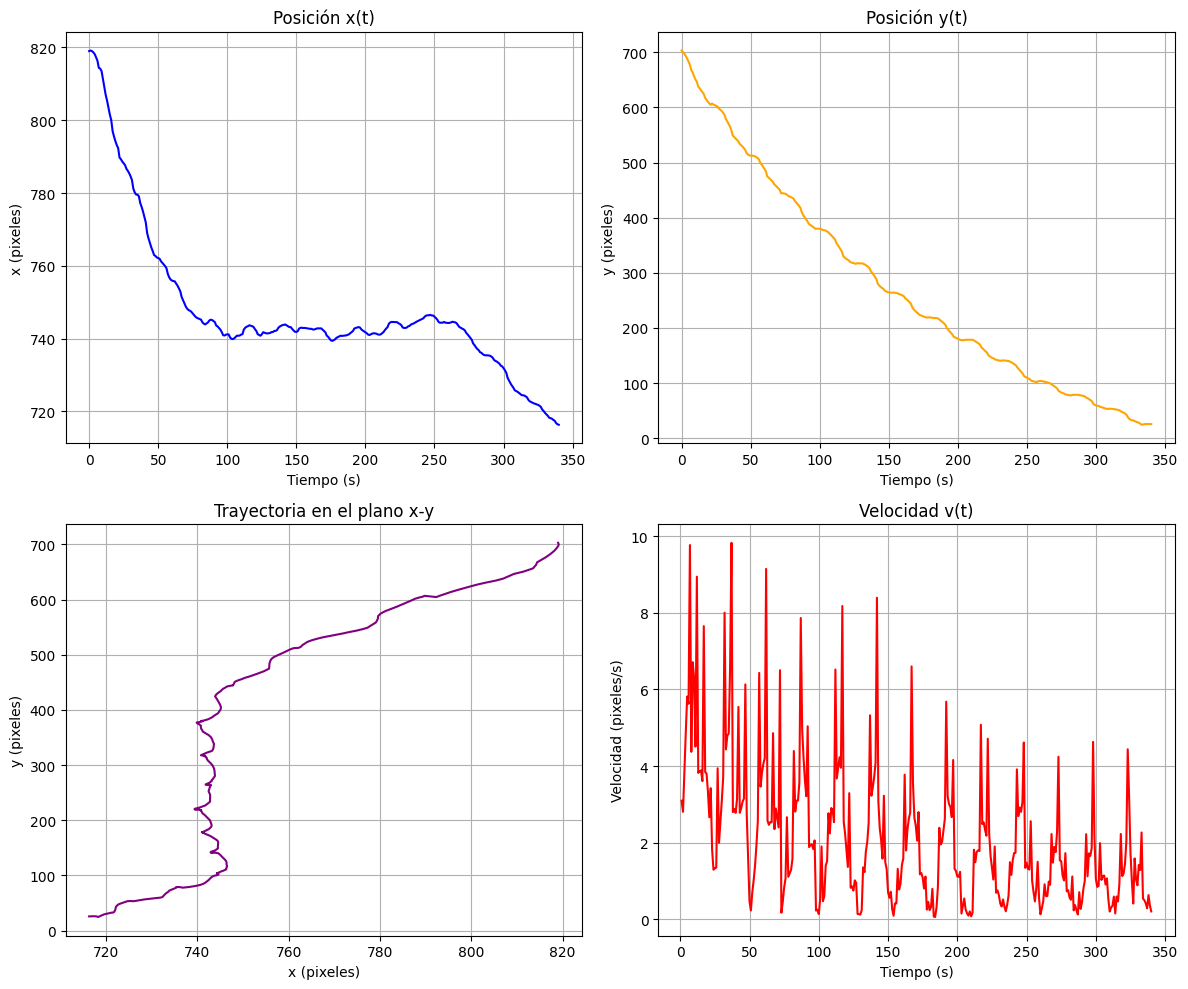

In [9]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(time, x_coordinates, label="x(t)", color="blue")
plt.xlabel("Tiempo (s)")
plt.ylabel("x (pixeles)")
plt.title("Posición x(t)")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(time, y_coordinates, label="y(t)", color="orange")
plt.xlabel("Tiempo (s)")
plt.ylabel("y (pixeles)")
plt.title("Posición y(t)")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(x_coordinates, y_coordinates, label="Trayectoria", color="purple")
plt.xlabel("x (pixeles)")
plt.ylabel("y (pixeles)")
plt.title("Trayectoria en el plano x-y")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(time[1:], speed, label="v(t)", color="red")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (pixeles/s)")
plt.title("Velocidad v(t)")
plt.grid()

plt.tight_layout()
plt.show()

### 2.2 Lucas Kanade desde 0

In [10]:
def build_image_pyramid(img, levels=3):
    """ Construye una pirámide Gaussiana de 'levels' niveles. """
    pyramid = [img]
    for i in range(1, levels):
        pyramid.append(cv.pyrDown(pyramid[i-1]))
    return pyramid

def lucas_kanade_step(I1, I2, pts, window_size=15, max_iter=10):
    """
    Aplica una iteración de Lucas-Kanade en un solo nivel (sin pirámide).
    I1, I2: imágenes en escala de grises (float32)
    pts: puntos Nx2 (x,y)
    window_size: tamaño de la ventana
    max_iter: iteraciones para refinar
    
    Devuelve el desplazamiento (u,v) para cada punto.
    """
    half_w = window_size // 2
    
    # Gradientes de la segunda imagen (I2)
    Ix = cv.Scharr(I2, cv.CV_32F, 1, 0)
    Iy = cv.Scharr(I2, cv.CV_32F, 0, 1)
    
    # Desplazamientos iniciales
    flow = np.zeros((pts.shape[0], 2), dtype=np.float32)
    
    for i, (x, y) in enumerate(pts):
        x0, y0 = x, y
        
        # Iteraciones para refinar el cálculo
        for _ in range(max_iter):
            # Coordenadas con desplazamiento actual
            x1 = x0 + flow[i,0]
            y1 = y0 + flow[i,1]
            
            # Asegurar que la ventana esté dentro de la imagen
            x_min = int(x1 - half_w)
            x_max = int(x1 + half_w + 1)
            y_min = int(y1 - half_w)
            y_max = int(y1 + half_w + 1)
            
            if x_min < 0 or y_min < 0 or x_max > I1.shape[1] or y_max > I1.shape[0]:
                break
            
            # Extraer parches
            I1_patch = I1[y_min:y_max, x_min:x_max]
            I2_patch = I2[y_min:y_max, x_min:x_max]
            Ix_patch = Ix[y_min:y_max, x_min:x_max]
            Iy_patch = Iy[y_min:y_max, x_min:x_max]
            
            # Diferencia temporal
            It_patch = I2_patch - I1_patch
            
            # Construir matrices A y b para el sistema A * [u;v] = b
            # A = [[sum(Ix^2), sum(IxIy)],
            #      [sum(IxIy), sum(Iy^2)]]
            # b = [[-sum(IxIt)],
            #      [-sum(IyIt)]]
            
            Ix_vec = Ix_patch.flatten()
            Iy_vec = Iy_patch.flatten()
            It_vec = It_patch.flatten()
            
            A11 = np.sum(Ix_vec * Ix_vec)
            A12 = np.sum(Ix_vec * Iy_vec)
            A21 = A12
            A22 = np.sum(Iy_vec * Iy_vec)
            
            b1 = -np.sum(Ix_vec * It_vec)
            b2 = -np.sum(Iy_vec * It_vec)
            
            A = np.array([[A11, A12],
                          [A21, A22]], dtype=np.float32)
            b = np.array([b1, b2], dtype=np.float32)
            
            # Resolvemos el sistema A * delta_flow = b
            # Usamos np.linalg.lstsq para ser más robustos
            delta_flow, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
            
            # Actualizar el flujo
            flow[i] += delta_flow
            
            # Si el cambio es muy pequeño, paramos
            if np.linalg.norm(delta_flow) < 0.01:
                break
    return flow

def calcOpticalFlowPyrLK_custom(I1, I2, pts, win_size=15, max_level=3, criteria=(10), **kwargs):
    """
    Implementación from scratch aproximada de cv.calcOpticalFlowPyrLK.
    I1, I2: imágenes (grises) en float32
    pts: Nx2 array de puntos
    win_size: Tamaño de la ventana Lucas-Kanade
    max_level: número de niveles de la pirámide
    criteria: número de iteraciones por nivel
    
    Devuelve: flujo estimado para cada punto.
    """
    # Construir pirámides
    pyr1 = build_image_pyramid(I1, levels=max_level)
    pyr2 = build_image_pyramid(I2, levels=max_level)
    
    # Escalar puntos para el nivel superior (más pequeño)
    scale = 1.0 / (2 ** (max_level-1))
    pts_scaled = pts * scale
    
    # Flujo inicial en el nivel superior
    flow = np.zeros_like(pts, dtype=np.float32)
    
    # Iterar desde el nivel superior al inferior
    for level in reversed(range(max_level)):
        # Escala actual
        current_scale = 2**(level)
        
        # Escalamos los puntos iniciales más el flujo acumulado
        pts_level = (pts + flow) * (1.0 / current_scale)
        
        # Refinar el flujo en este nivel
        delta = lucas_kanade_step(pyr1[level], pyr2[level], pts_level, window_size=win_size, max_iter=criteria)
        
        # Actualizar el flujo total
        flow += delta * current_scale
    
    return flow

In [11]:
import time 

scale_percent = 120 / 100


video = cv.VideoCapture("../videos/people2.mp4")
status, full_res_frame = video.read()

if not status:
    raise ValueError("No se pudo leer el primer frame del video.")

original_height, original_width = full_res_frame.shape[:2]

# Cargar el modelo YOLO
model = YOLO('./models/yolo11x-pose.pt')

# 1. Detectar la mano en la resolución original
hand_point_full = get_hand(full_res_frame, model)

# 2. Redimensionar el frame a la resolución deseada
target_width = int(original_width * scale_percent)
target_height = int(original_height * scale_percent)
reduced_frame = cv.resize(full_res_frame, (target_width, target_height), interpolation=cv.INTER_AREA)

# Ajustar las coordenadas de la mano a la nueva resolución
scale_x = target_width / original_width
scale_y = target_height / original_height
hand_point = (int(hand_point_full[0] * scale_x), int(hand_point_full[1] * scale_y))

size = (reduced_frame.shape[1], reduced_frame.shape[0])
fourcc = cv.VideoWriter_fourcc(*'mp4v')
video_out = cv.VideoWriter('../videos/lk_mano.mp4', fourcc, 20.0, size)

old_gray = cv.cvtColor(reduced_frame, cv.COLOR_BGR2GRAY)

video_out.write(reduced_frame)

tracking_path = [hand_point]
tracking_path_skips = [hand_point]
i = 0
frames = [i]   

lk_params = dict(winSize=(15, 15),  
                 maxLevel=4,
                 criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

prev_points = np.array([hand_point], dtype=np.float32).reshape(-1, 1, 2)

compute_start = time.time()

while True:
    ret, full_res_frame = video.read()
    if not ret:
        break
    
    # Redimensionar el frame a la resolución deseada
    frame = cv.resize(full_res_frame, (target_width, target_height), interpolation=cv.INTER_AREA)

    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    old_gray_float = old_gray.astype(np.float32)/255.0
    gray_float = gray.astype(np.float32)/255.0

    winSize = lk_params.get('winSize', (15,15))
    maxLevel = lk_params.get('maxLevel', 2)
    criteria = lk_params.get('criteria', (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
    iterations = criteria[1] if len(criteria) > 1 else 10

    current_points = prev_points.reshape(-1, 2)
    flow = calcOpticalFlowPyrLK_custom(old_gray_float, gray_float, current_points,
                                       win_size=winSize[0], max_level=maxLevel, criteria=iterations)

    next_points = prev_points + flow.reshape(-1, 1, 2)

    if np.all(np.isfinite(flow)):
        status = np.array([[1]], dtype=np.uint8)
    else:
        status = np.array([[0]], dtype=np.uint8)

    new_tracked_points = []
    if status[0][0] == 1:
        x, y = next_points[0][0]
        new_tracked_points.append((x, y))
        tracking_path.append((x, y))
        tracking_path_skips.append((x, y))
        prev_points = next_points
    else:
        tracking_path_skips.append((0,0))
        new_tracked_points = tracking_path[-1:]

    i += 1
    frames.append(i)
    
    # Dibujar la trayectoria
    for i in range(1, len(tracking_path)):
        cv.line(frame,
                (int(tracking_path[i-1][0]), int(tracking_path[i-1][1])),
                (int(tracking_path[i][0]), int(tracking_path[i][1])),
                (255, 0, 0), 2)

    for (x, y) in new_tracked_points:
        cv.circle(frame, (int(x), int(y)), 5, (0, 255, 0), -1)

    cv.imshow('Lucas-Kanade - Mano (Resolucion Reducida)', frame)
    video_out.write(frame)

    old_gray = gray.copy()

    if cv.waitKey(1) & 0xFF == 27:
        break

compute_end = time.time()
video.release()
video_out.release()
cv.destroyAllWindows()


0: 384x640 7 persons, 598.6ms
Speed: 3.2ms preprocess, 598.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


In [12]:
spent_time = compute_end - compute_start
spent_time_min = spent_time / 60
print(f"Time spent: {spent_time} seconds")
print(f"Time spent: {spent_time_min} minutes")

Time spent: 21.888510704040527 seconds
Time spent: 0.3648085117340088 minutes


In [13]:
x_coordinates = [float(point[0]) if hasattr(point[0], 'item') else point[0] for point in tracking_path]
y_coordinates = [float(point[1]) if hasattr(point[1], 'item') else point[1] for point in tracking_path]
x_skip = [float(point[0]) if hasattr(point[0], 'item') else point[0] for point in tracking_path_skips]
y_skip = [float(point[1]) if hasattr(point[1], 'item') else point[1] for point in tracking_path_skips]
time = [i for i in range(len(tracking_path))]
speed = np.sqrt(np.diff(x_coordinates)**2 + np.diff(y_coordinates)**2)

data = {
    "x_coordinates": x_coordinates,
    "y_coordinates": y_coordinates,
    "x_skip": x_skip,
    "y_skip": y_skip,
    "time": time,
    "time_frame": frames,
    "speed": speed.tolist(),
    "time_spent": spent_time
}

savedata = SaveData(data, "tracking_lk_mano")
savedata.save_data()

Datos guardados en ../resultados\tracking_lk_mano.txt


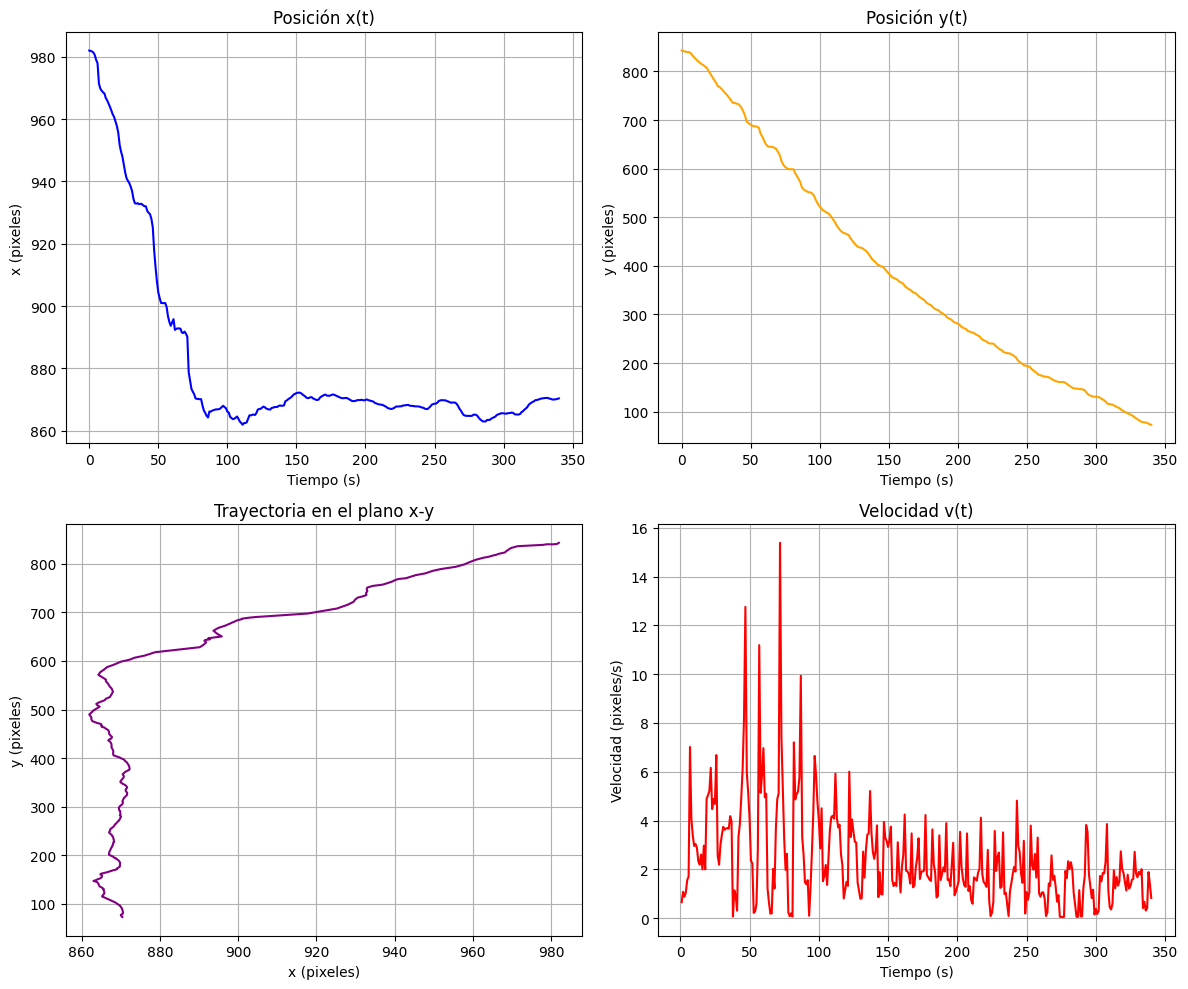

In [14]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(time, x_coordinates, label="x(t)", color="blue")
plt.xlabel("Tiempo (s)")
plt.ylabel("x (pixeles)")
plt.title("Posición x(t)")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(time, y_coordinates, label="y(t)", color="orange")
plt.xlabel("Tiempo (s)")
plt.ylabel("y (pixeles)")
plt.title("Posición y(t)")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(x_coordinates, y_coordinates, label="Trayectoria", color="purple")
plt.xlabel("x (pixeles)")
plt.ylabel("y (pixeles)")
plt.title("Trayectoria en el plano x-y")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(time[1:], speed, label="v(t)", color="red")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (pixeles/s)")
plt.title("Velocidad v(t)")
plt.grid()

plt.tight_layout()
plt.show()